# Data preprocessing

Using dataset National Flowers, which has 9 classes of flowers:

- daisy
- dandelion
- lavender
- lilly
- lotus
- orchid
- rose
- sunflower
- tulip
---------

## Loading data

We need to load data and split it into 3 pieces:
- 20% test
- 16% validation
- 64% train

In [1]:
import os
import random
import shutil
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

In [2]:
# Train data normalizing and augmentation settings:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Val and test data normalizing and augmentation settings:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "/kaggle/input/national-flowers-vdandelion/National Flowers vDandelion"
class_names = os.listdir(os.path.join(dataset_path, 'train'))
number_of_classes = len(class_names)

In [5]:
# 1. Load and transform as training all train data
full_train_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'), transform=train_transform)

In [6]:
# 2. Split train data into train and validation data
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [7]:
# 3. Load and transform as validation only already splitted val data
val_dataset = Subset(datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'), transform=val_test_transform), val_dataset.indices)

In [8]:
# 4. Load and transform as testing all test data
test_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'test'), transform=val_test_transform)

## Generating data batches

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Function to colorize output
def colored_print(text: str, color: str = 'grey'):
    if color == 'grey':
        print(f"\033[90m{text}\033[0m")
    elif color == 'r':
        print(f"\033[91m{text}\033[0m")
    elif color == 'g':
        print(f"\033[92m{text}\033[0m")
    elif color == 'y':
        print(f"\033[93m{text}\033[0m")
    elif color == 'm':
        print(f"\033[95m{text}\033[0m")
    elif color == 'c':
        print(f"\033[96m{text}\033[0m")

## Saving and fetching best params

In [11]:
# Fetching best models' params from GitHub
best_models_path = "/kaggle/working/"

# Building and training models

We are going to build, train and score 4 models:

- simple custom CNN model
- pretrained ResNet50
- pretrained MobileNet
- pretrained EfficientNet

## Simple CNN

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [13]:
# Initialising a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, number_of_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 112 * 112, number_of_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 112 * 112)
        x = self.fc1(x)
        return x

In [14]:
def train_cnn():
    colored_print(f'Simple CNN', 'g')
    # using GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    colored_print(f'Using device: {device}')

    cnn = SimpleCNN(number_of_classes).to(device)

    # defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)

    # training a model
    epochs = 20
    best_cnn_params = dict({})
    best_cnn_accuracy = 0
    for epoch in range(epochs):
        cnn.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'\nEpoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.2f}')

        # validation
        cnn.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = cnn(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.2f}, Accuracy: {validation_accuracy:.2f}')
        
        # save params if accuracy is better
        if validation_accuracy > best_cnn_accuracy:
            best_cnn_accuracy = validation_accuracy
            best_cnn_params = cnn.state_dict()
            
        
    # load params with the best accuracy
    cnn.load_state_dict(best_cnn_params)
    colored_print(f'\nBest accuracy achieved: {best_cnn_accuracy:.2f}', 'g')
    return cnn
    
cnn = train_cnn()

Simple CNN
Using device: cuda

Epoch [1/20], Loss: 28.26
Validation Loss: 5.57, Accuracy: 49.72

Epoch [2/20], Loss: 6.38
Validation Loss: 3.54, Accuracy: 48.89

Epoch [3/20], Loss: 4.07
Validation Loss: 3.57, Accuracy: 47.78

Epoch [4/20], Loss: 3.30
Validation Loss: 3.06, Accuracy: 52.36

Epoch [5/20], Loss: 2.92
Validation Loss: 2.78, Accuracy: 51.81

Epoch [6/20], Loss: 2.32
Validation Loss: 2.17, Accuracy: 55.42

Epoch [7/20], Loss: 1.80
Validation Loss: 1.81, Accuracy: 57.36

Epoch [8/20], Loss: 1.68
Validation Loss: 1.75, Accuracy: 57.92

Epoch [9/20], Loss: 1.42
Validation Loss: 1.61, Accuracy: 60.97

Epoch [10/20], Loss: 1.34
Validation Loss: 1.52, Accuracy: 61.25

Epoch [11/20], Loss: 1.30
Validation Loss: 1.47, Accuracy: 59.72

Epoch [12/20], Loss: 1.14
Validation Loss: 1.44, Accuracy: 61.67

Epoch [13/20], Loss: 1.13
Validation Loss: 1.47, Accuracy: 59.58

Epoch [14/20], Loss: 1.04
Validation Loss: 1.35, Accuracy: 61.53

Epoch [15/20], Loss: 1.10
Validation Loss: 1.36, Accu

In [15]:
torch.save(cnn.state_dict(), os.path.join(best_models_path, 'cnn.pth'))

## ResNet50

In [16]:
import torch
import torch.optim as optim
import torchvision.models as models

In [17]:
# Initialising a ResNet50 model
resnet50 = models.resnet50(pretrained=True)
number_of_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(number_of_features, number_of_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [18]:
def train_resnet50(resnet50):
    colored_print(f'ResNet50', 'g')
    # using GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    colored_print(f'Using device: {device}')

    resnet50 = resnet50.to(device)

    # training last layers
    for param in resnet50.parameters():
        param.requires_grad = False
    for param in resnet50.fc.parameters():
        param.requires_grad = True

    # defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

    # training a model
    epochs = 50
    best_resnet50_params = dict({})
    best_resnet50_accuracy = 0
    for epoch in range(epochs):
        resnet50.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'\nEpoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.2f}')

        # validation
        resnet50.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = resnet50(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.2f}, Accuracy: {validation_accuracy:.2f}')
        
        # save params if accuracy is better
        if validation_accuracy > best_resnet50_accuracy:
            best_resnet50_accuracy = validation_accuracy
            best_resnet50_params = resnet50.state_dict()
            
        
    # load params with the best accuracy
    resnet50.load_state_dict(best_resnet50_params)
    colored_print(f'\nBest accuracy achieved: {best_resnet50_accuracy:.2f}', 'g')

    return resnet50

resnet50 = train_resnet50(resnet50)

ResNet50
Using device: cuda

Epoch [1/50], Loss: 1.19
Validation Loss: 0.70, Accuracy: 80.97

Epoch [2/50], Loss: 0.70
Validation Loss: 0.55, Accuracy: 81.11

Epoch [3/50], Loss: 0.59
Validation Loss: 0.48, Accuracy: 85.28

Epoch [4/50], Loss: 0.53
Validation Loss: 0.43, Accuracy: 86.67

Epoch [5/50], Loss: 0.50
Validation Loss: 0.41, Accuracy: 88.06

Epoch [6/50], Loss: 0.46
Validation Loss: 0.45, Accuracy: 85.69

Epoch [7/50], Loss: 0.44
Validation Loss: 0.42, Accuracy: 86.25

Epoch [8/50], Loss: 0.45
Validation Loss: 0.40, Accuracy: 87.64

Epoch [9/50], Loss: 0.41
Validation Loss: 0.38, Accuracy: 89.03

Epoch [10/50], Loss: 0.40
Validation Loss: 0.38, Accuracy: 87.78

Epoch [11/50], Loss: 0.40
Validation Loss: 0.38, Accuracy: 87.64

Epoch [12/50], Loss: 0.40
Validation Loss: 0.40, Accuracy: 87.50

Epoch [13/50], Loss: 0.38
Validation Loss: 0.39, Accuracy: 87.36

Epoch [14/50], Loss: 0.37
Validation Loss: 0.36, Accuracy: 89.17

Epoch [15/50], Loss: 0.36
Validation Loss: 0.40, Accurac

In [19]:
torch.save(resnet50.state_dict(), os.path.join(best_models_path, 'resnet50.pth'))

# Score models

*You need to initialize all models' classes.*

- initialize a model's object
- load best params from /best_models/model.pth
- model is ready to be evaluated

## Score function

In [20]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def score_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, f1, conf_matrix

In [22]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):   
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('PREDICTED')
    plt.ylabel('TRUE')
    plt.title(f'{model_name} Confusion Matrix')
    
    plt.text(0.5, -0.1, f'accuracy: {accuracy:.2f}', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=10)
    plt.show()

## Score Simple CNN

In [23]:
# path to best params
best_cnn_params_path = os.path.join(best_models_path, 'cnn.pth')

# load best params into model
cnn = SimpleCNN(number_of_classes)
cnn.load_state_dict(torch.load(best_cnn_params_path))

<ipython-input-23-9274c6a94150>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load(best_cnn_params_path))


<All keys matched successfully>

In [24]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

# model is ready for use

In [25]:
cnn_accuracy, cnn_f1_score, cnn_confusion_matrix = score_model(cnn)

Accuracy: 0.50, f1-score: 0.49


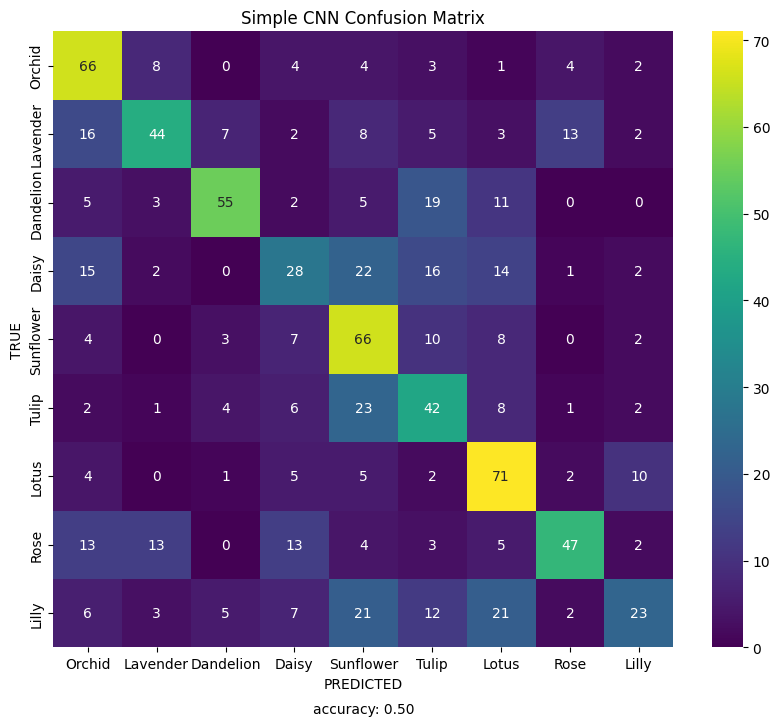

In [26]:
colored_print(f'Accuracy: {cnn_accuracy:.2f}, f1-score: {cnn_f1_score:.2f}', 'g')
plot_confusion_matrix(cnn_confusion_matrix, 'Simple CNN', cnn_accuracy)

## Score ResNet50

In [27]:
# path to best params
best_resnet50_params_path = os.path.join(best_models_path, 'resnet50.pth')

# load best params into model
resnet50.load_state_dict(torch.load(best_resnet50_params_path))

<ipython-input-27-cb2d8b196d9e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load(best_resnet50_params_path))


<All keys matched successfully>

In [28]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# model is ready for use

In [29]:
resnet50_accuracy, resnet50_f1_score, resnet50_confusion_matrix = score_model(resnet50)

Accuracy: 0.84, f1-score: 0.84


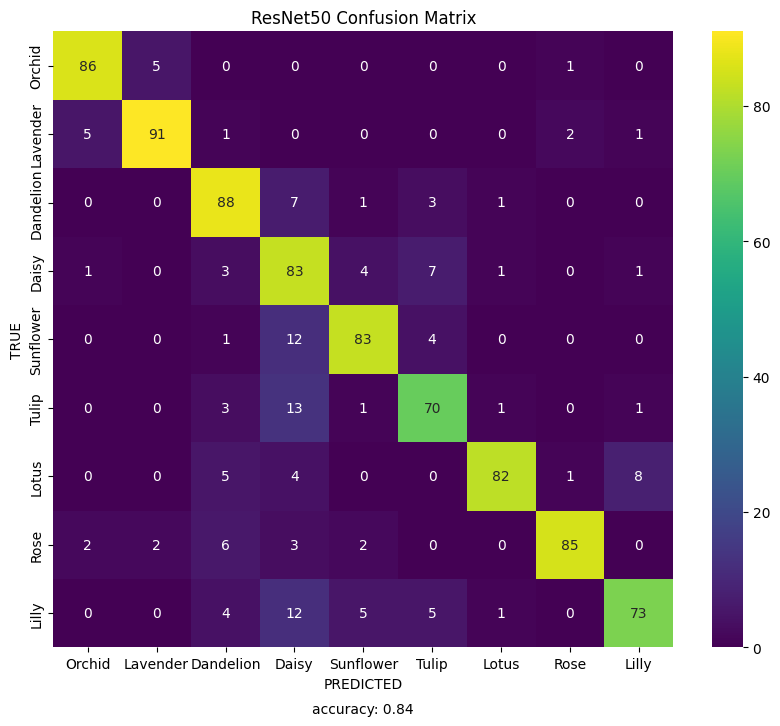

In [30]:
colored_print(f'Accuracy: {resnet50_accuracy:.2f}, f1-score: {resnet50_f1_score:.2f}', 'g')
plot_confusion_matrix(resnet50_confusion_matrix, 'ResNet50', resnet50_accuracy)